In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras as keras
from keras import layers as layers
import numpy as np

In [3]:
import os
import cv2
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from math import inf as inf
import numpy as np

In [4]:
from spectral.io import envi as envi
from spectral import imshow

In [5]:
from sklearn.decomposition import IncrementalPCA

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
#Testing Constants
TESTING = True

#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.7
IMAGE_COUNT = 10
DATA_DIRECTORY = "D:\mvl\wheat\data\BULK\\"

In [8]:
# List for All varieties
VARIETIES = []
for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES.append(name)

In [9]:
#List for all file names in varities
FILES = []
MAX_FILE_NUM = 4
for x in range(1,MAX_FILE_NUM+1):
    FILES.append("B_"+str(x))

In [10]:
def exactPathHDR(variety,file):
    return DATA_DIRECTORY+variety+"\\"+file+".bil.hdr"

def exactPathBIL(variety,file):
    return DATA_DIRECTORY+variety+"\\"+file+".bil"

In [11]:
#List of all images
images = []
images_label = []
for v in VARIETIES:
    for f in FILES:
        try:
            img = envi.open(exactPathHDR(v,f),exactPathBIL(v,f))
            images.append(img)
            images_label.append(v)
        except:
            pass

In [12]:
def getROI(img,band_number):
    img_band = img.read_band(band_number)
    threshold = threshold_otsu(img_band)
    roi=[]
    for x in range(img_band.shape[0]):
        a=[]
        for y in range(img_band.shape[1]):
            if img_band[x][y]>threshold:
                a.append(1)
            else:
                a.append(0)
        roi.append(a)
    return roi

In [13]:
#Returns range for x and y from where we have to crop images
def getRangeXandY(img,band_number):
    img_band = img.read_band(band_number)
    roi = getROI(img,band_number)
    xmin = inf
    xmax = 0
    ymin = inf
    ymax = 0
    for x in range(img_band.shape[0]):
        for y in range(img_band.shape[1]):
            if roi[x][y]==1:
                if x<xmin:
                    xmin=x
                if x>xmax:
                    xmax=x
                if y<ymin:
                    ymin=y
                if y>ymax:
                    ymax=y
    return xmin, xmax, ymin, ymax

In [14]:
def getCroppedImage(img,band_number):
    xmin, xmax, ymin, ymax = getRangeXandY(img,band_number)
    new_img = img[xmin:xmax, ymin:ymax, :]
    return new_img    

In [15]:
def getCroppedROI(img,band_number):
    xmin, xmax, ymin, ymax = getRangeXandY(img,band_number)
    roi = np.array(getROI(img,band_number))
    roi = roi[xmin:xmax, ymin:ymax]
    return roi   

In [16]:
def getUsefulImage(img,band_number):
    crop_img = getCroppedImage(img,band_number)
    crop_roi = getCroppedROI(img,band_number)
    for x in range(crop_img.shape[2]):
        band = crop_img[:,:,x]
        crop_img[:,:,x] = band*crop_roi
    return crop_img

In [17]:
data_augmentation = keras.Sequential([
    layers.RandomCrop(height=40, width=40),
    layers.RandomRotation(factor=(-0.1, 0.1)),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1,0.1)),
])

def getAugumentedImage(img,band_number):
    new_img = getUsefulImage(img,band_number)
    augmented_image = data_augmentation(new_img) 
    return augmented_image

def checkAugumentedImage(augmented_image):
    aug_band = augmented_image[:,:,0]
    filled_area_ratio = (np.count_nonzero(aug_band))/(aug_band.shape[0]*aug_band.shape[1])
    if filled_area_ratio > FILLED_AREA_RATIO :
        return True
    else:
        return False

In [18]:
## Dimensional Reduction Method
def DL_Method(HSI, numComponents = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    n_batches = 10
    inc_pca = IncrementalPCA(n_components=numComponents)
    for X_batch in np.array_split(RHSI, n_batches):
        inc_pca.partial_fit(X_batch)
    X_ipca = inc_pca.transform(RHSI)
    RHSI = np.reshape(X_ipca, (HSI.shape[0],HSI.shape[1], numComponents))
    return RHSI

In [19]:
train_dataset = []
train_dataset_label = []
test_dataset = []
test_dataset_label = []

for index, img in enumerate(images):
    count = 0
    label = images_label[index]
    while count<IMAGE_COUNT:
        aug_img = getAugumentedImage(img,BAND_NUMBER)
        
        if checkAugumentedImage(aug_img):
            aug_img = DL_Method(aug_img[:,:,21:150])
            if count%5 == 0:
                test_dataset.append(aug_img)
                test_dataset_label.append(label)
            else:
                train_dataset.append(aug_img)
                train_dataset_label.append(label)
            count+=1  
            
    if TESTING:
        break

DBW 187
DBW 187


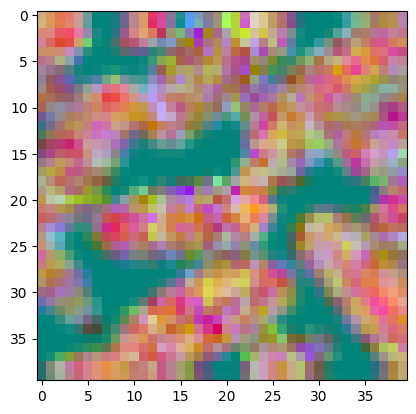

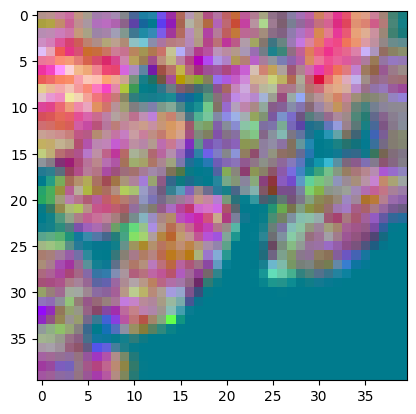

In [20]:
for index,data in enumerate(test_dataset):
    imshow(data)
    print(test_dataset_label[index])
    

DBW 187
DBW 187
DBW 187
DBW 187
DBW 187
DBW 187
DBW 187
DBW 187


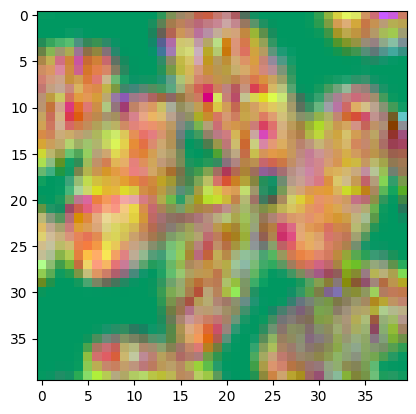

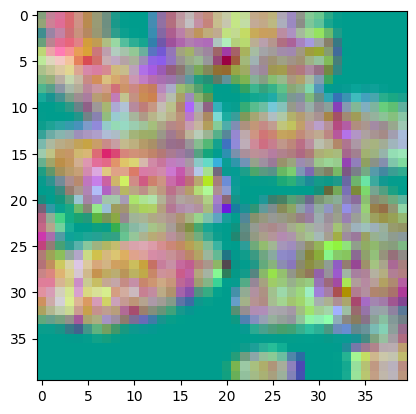

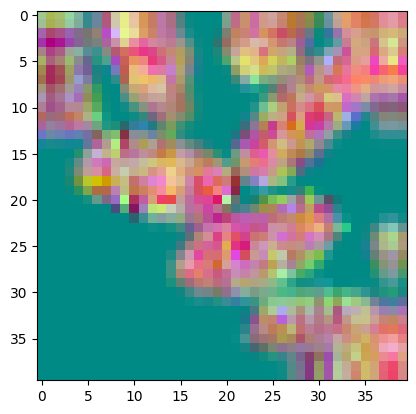

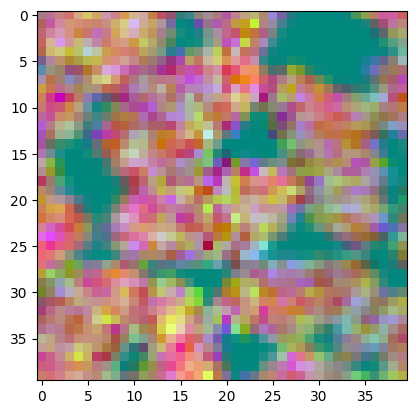

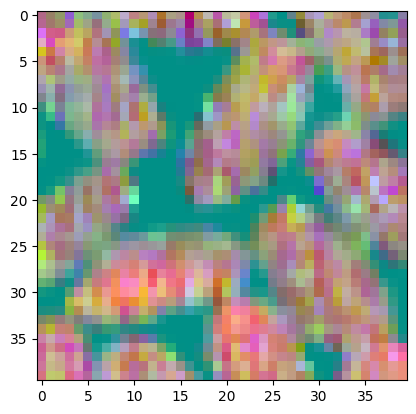

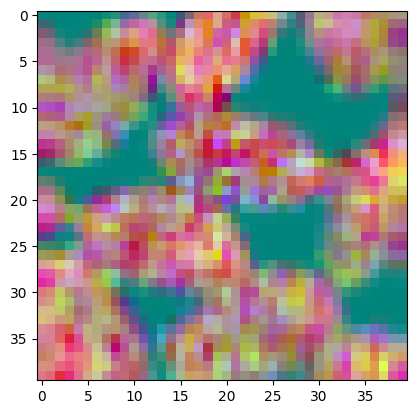

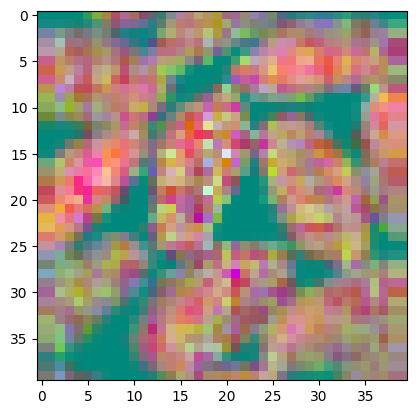

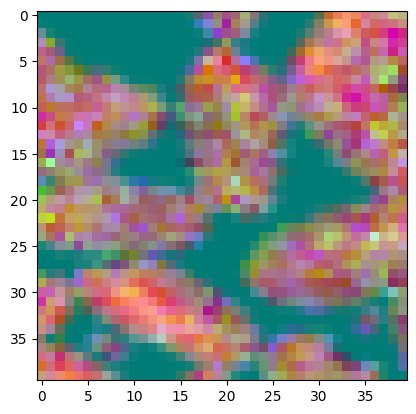

In [21]:
for index,data in enumerate(train_dataset):
    imshow(data)
    print(train_dataset_label[index])

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
# import math, sys, pdb, os
import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, Conv2DTranspose, Flatten, Dense, Conv1D, AveragePooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D
from keras.layers.core import Dropout
from keras.layers import concatenate
from keras.models import Model

import os, pdb, timeit
import numpy as np
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.cm as cm
import cv2
from keras import activations
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils

ImportError: cannot import name 'Iterable' from 'collections' (C:\Users\ganga\anaconda3\envs\tensorflow-gpu\lib\collections\__init__.py)

In [33]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:]) # L2-norm by default        
        
    return data

In [34]:
def make_hyperparam_string(USE_DATA_AUG, learning_rate_base, batch_size, kernel_size, dropout_rate, num_training,
                           num_nodes_fc, activation_type):
    hparam = ""

    # Hyper-parameters
    if USE_DATA_AUG:
        hparam += "AUG_"

    hparam += str(num_nodes_fc) + "nodes_" + str(learning_rate_base) + "lr_" + str(batch_size) + "batch_" + str(
        kernel_size) + "kernel_" + str(dropout_rate) + "drop_" + str(
        num_training) + "train_" + activation_type

    return hparam

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.clim(0,sum(cm[0,:]))
    plt.xlabel('Predicted label')

In [36]:
def top_K_classification_accuracy(y_predicted, y_true, K=1):

    num_samples = y_predicted.shape[0]
    num_classes = y_predicted.shape[1]

    if K > num_classes:
        sys.exit(1)

    temp = np.zeros((num_samples,))

    for idx in range(num_samples):
        curr_predicted = np.argsort(y_predicted[idx,:])
        curr_predicted = curr_predicted[::-1] # descending

        if y_true[idx] in curr_predicted[:K]:
            temp[idx] = 1

    return 100.0 * np.sum(temp)/num_samples

In [37]:
def conv2D_ResNet(x, kernel_size, activation_type, dropout_rate, num_filters_first_conv1D):

    x_orig = x

    # Batch norm
    x = BatchNormalization()(x)

    # 1x1 Conv2D
    x = Conv2D(num_filters_first_conv1D, kernel_size=1, activation=None, use_bias=False, padding='same',
               kernel_initializer='truncated_normal')(x)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    x = BatchNormalization()(x)

    # 3x3 Conv2D
    x = Conv2D(num_filters_first_conv1D, kernel_size, activation=None, use_bias=True, padding='same',
               kernel_initializer='truncated_normal')(x)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    x = BatchNormalization()(x)

    # 1x1 Conv2D
    x = Conv2D(num_filters_first_conv1D*4, kernel_size=1, activation=None, use_bias=False, padding='same',
               kernel_initializer='truncated_normal')(x)

    # Skip connection
    if int(x.shape[3]) != int(x_orig.shape[3]):
        x_orig = Conv2D(int(x.shape[3]), kernel_size=1, activation=None, use_bias=False, padding='same',
               kernel_initializer='truncated_normal')(x_orig)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    x = Add()([x, x_orig])

    # Dropout
    return Dropout(dropout_rate)(x)

In [38]:
def createBlock_ResNet2D(x, num_layers, kernel_size, activation_type, dropout_rate, num_filters_first_conv1D):

    for idx_layer in range(num_layers):

        x = conv2D_ResNet(x, kernel_size, activation_type, dropout_rate, num_filters_first_conv1D)

    return x

In [39]:
# growth_rate: number of filters for each normal convolution ('k' in the paper)
def ResNet2D_classifier(data_num_rows, data_num_cols, num_classes, kernel_size=3, num_layers_each_block=[6, 12, 24, 16],
                        num_chan_per_block = [64,128,256,512], activation_type='swish', dropout_rate=0.0, num_input_chans=1, num_nodes_fc=64):

    input_data = Input(shape=(data_num_rows, data_num_cols, num_input_chans))

    # Input layer: Conv2D -> activation
    x = Conv2D(num_chan_per_block[0], kernel_size, activation=None, use_bias=True, padding='same',
               kernel_initializer='truncated_normal')(input_data)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    #  Blocks & Downsampling Layers
    for idx_block in range(len(num_layers_each_block)):
        x = createBlock_ResNet2D(x, num_layers_each_block[idx_block], kernel_size, activation_type, dropout_rate,
                                 num_chan_per_block[idx_block])

        x = BatchNormalization()(x)

        if idx_block != len(num_layers_each_block)-1:
            x = Conv2D(num_chan_per_block[idx_block]*2, kernel_size, strides = 2, activation=None, use_bias=True, padding='valid',
                   kernel_initializer='truncated_normal')(x)
        else:
            x = GlobalAveragePooling2D()(x)

        x = Dropout(dropout_rate)(x)

    # Output layer
    x = BatchNormalization()(x)
    x = Dense(units=num_nodes_fc, activation=None, kernel_initializer='truncated_normal')(x)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    x = BatchNormalization()(x)
    output_data = Dense(units=num_classes, activation='softmax', kernel_initializer='truncated_normal')(x)

    return Model(inputs=input_data, outputs=output_data)

In [40]:
def createAndTrainResNetB(params):
                                        
    ############ Extract params ############
    USE_DATA_AUG = params['USE_DATA_AUG']
    learning_rate_base = params['learning_rate_base']
    kernel_size = params['kernel_size']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']
    dropout_rate = params['dropout_rate']
    activation_type = params['activation_type']
    num_nodes_fc = params['num_nodes_fc']
    wheat_types = params['wheat_types']
    normalization_type = params['normalization_type']
    num_layers_each_block = params['num_layers_each_block']
    num_chan_per_block = params['num_chan_per_block']
    N_classes = len(wheat_types)
    
    
    ############ Load data ############
    print("--------------Load Data--------------")

    # Load training data and their corresponding labels
    x_training = np.load('x.npy')
    labels_training = np.load('labels.npy')
    
    # Normalize the data
    x_training = normalizeDataWholeSeed(x_training,normalization_type=normalization_type)
    
    # Extract some information
    num_training = x_training.shape[0]
    N_spatial = x_training.shape[1:3]
    N_bands = x_training.shape[3]
    num_batch_per_epoch = int(num_training/batch_size)
    
    print('#training = %d' %(num_training))
    print('#batches per epoch = %d' %(num_batch_per_epoch))
    
    print("--------------Done--------------")
    
    
    ############ Prepare the path for saving the models/stats ############
    print("--------------Prepare a path for saving the models/stats--------------")
    
    hparams = make_hyperparam_string(USE_DATA_AUG, learning_rate_base, batch_size, kernel_size, dropout_rate,
                                     num_training, num_nodes_fc, activation_type)
    print('Saving the model to...')
    
    results_dir = os.path.join(params['results_base_directory'],hparams)
    
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    print(results_dir)

    print("--------------Done--------------")

    ############ Create a model ############
    print("--------------Create a model--------------")
    
    # Generate a model
    model = ResNet2D_classifier(data_num_rows=N_spatial[0], data_num_cols=N_spatial[1], num_classes=N_classes,
                                kernel_size=kernel_size, num_layers_each_block=num_layers_each_block,
                                num_chan_per_block=num_chan_per_block, activation_type=activation_type,
                                dropout_rate=dropout_rate, num_input_chans=N_bands, num_nodes_fc=num_nodes_fc)

    # Compile the model
    adam_opt = Adam(lr=learning_rate_base / batch_size, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['acc'])

    # Create a Tensorboard callback
    tbCallBack = TensorBoard(log_dir=results_dir, histogram_freq=0, write_graph=False, write_images=False)
    
    print("--------------Done--------------")

    ############ Train the model ############
    print("--------------Begin training the model--------------")

    # Possibly perform data augmentation
    from keras.preprocessing.image import ImageDataGenerator
    
    if USE_DATA_AUG:
        width_shift_range = 0.04
        height_shift_range = 0.04
        HORIZONTAL_FLIP = True
        VERTICAL_FLIP = True
        data_gen_args = dict(
            rotation_range=0.,
            width_shift_range=width_shift_range,
            height_shift_range=height_shift_range,
            horizontal_flip=HORIZONTAL_FLIP,
            vertical_flip=VERTICAL_FLIP,
            fill_mode = 'wrap')

        image_datagen = ImageDataGenerator(**data_gen_args)
    else:
        image_datagen = ImageDataGenerator()

    # Define a data generator to generate random batches
    def myGenerator(batch_size):
        for x_batch, y_batch in image_datagen.flow(x_training, labels_training, batch_size=batch_size, shuffle = True):
            yield (x_batch, y_batch)

    my_generator = myGenerator(batch_size)

    tic = timeit.default_timer()
    
    # Train the model
    hist = model.fit_generator(my_generator, steps_per_epoch=num_batch_per_epoch, epochs = num_epochs, initial_epoch = 0, verbose=2, callbacks = [tbCallBack])

    toc = timeit.default_timer()
    training_time = toc-tic
    print("Total training time = " + str(training_time))
    
    print("--------------Done--------------")

    print("--------------Make Predictions--------------")
    # In this example script, we use the training data as the test data
    x_test = x_training
    labels_test = labels_training
    num_test = num_training

    tic = timeit.default_timer()
    labels_predicted_test = model.predict(x_test)
    toc = timeit.default_timer()
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

    ### Evaluation metrics

    # Classification accuracy
    labels_test_integer_format = np.argmax(labels_test, axis=1)
    labels_predicted_test_integer_format = np.argmax(labels_predicted_test, axis=1)

    acc_top2 = top_K_classification_accuracy(labels_predicted_test, labels_test_integer_format, K=2)
    acc_top1 = top_K_classification_accuracy(labels_predicted_test, labels_test_integer_format, K=1)

    # Confusion matrices
    confusion_matrix_results = confusion_matrix(labels_test_integer_format, labels_predicted_test_integer_format)
    print("Confusion matrix = ")
    print(confusion_matrix_results)

    # Precision, Recall, F1
    macro_avg = np.asarray(
        precision_recall_fscore_support(labels_test_integer_format, labels_predicted_test_integer_format,
                                        average='macro'))
    macro_avg_precision = macro_avg[0]
    macro_avg_recall = macro_avg[1]
    macro_avg_fscore = macro_avg[2]

    print('Top-1 accuracy (%) = ' + str(acc_top1) + '\n')
    print('Top-2 accuracy (%) = ' + str(acc_top2) + '\n')
    print('Macro-avg precision = ' + str(macro_avg_precision) + '\n')
    print('Macro-avg recall = ' + str(macro_avg_recall) + '\n')
    print('Macro-avg f-score = ' + str(macro_avg_fscore) + '\n')

    print("--------------Done--------------")

    print("--------------Compute Saliency Maps--------------")
    results_test_dir = os.path.join(results_dir, 'test')
    if not os.path.exists(results_test_dir):
        os.makedirs(results_test_dir)

    # Swap softmax with linear
    model.layers[-1].activation = activations.linear
    model = utils.apply_modifications(model)

    for idx_wheat in range(num_test):

        grads = visualize_saliency(model, layer_idx=-1, filter_indices=np.argmax(labels_test[idx_wheat, :], axis=0),
                                   seed_input=x_test[idx_wheat], backprop_modifier=None)

        ss_img = np.sqrt(np.sum(abs(x_test[idx_wheat, :, :, :]) ** 2, axis=2))
        ss_img /= np.max(ss_img)

        plt.figure(1)
        plt.subplot(3, 1, 1)
        plt.imshow(ss_img, cmap='gray')
        plt.clim(0, 1)
        plt.axis('off')
        plt.colorbar()

        plt.subplot(3, 1, 2)
        plt.imshow((grads * np.uint8(255)).astype('uint8'), cmap='jet')
        plt.clim(0, 255)
        plt.axis('off')
        plt.colorbar()

        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * np.uint8(255))

        plt.subplot(3, 1, 3)
        ss_img = cv2.cvtColor((ss_img * np.uint8(255)).astype('uint8'), cv2.COLOR_GRAY2RGB)
        plt.imshow(overlay(jet_heatmap, ss_img, alpha=0.3))
        plt.clim(0, 255)
        plt.axis('off')
        plt.colorbar()

        plt.savefig(os.path.join(results_test_dir, str(idx_wheat+1) + '.png'))
        plt.clf()

    print("--------------Done--------------")

    print("--------------Save the information--------------")

    # Write some information to files
    f = open(os.path.join(results_test_dir, 'testing_info.txt'), 'w')
    f.write("Wheat types = " + str(wheat_types) + "\n")
    f.write("Confusion matrix \n")
    f.write(str(confusion_matrix_results) + "\n")
    f.write("Normalization type = " + str(normalization_type) + "\n")
    f.write("# test samples = %d \n" % (num_test))
    f.write("Top-1 test accuracy = %f \n" % (acc_top1))
    f.write("Top-2 test accuracy = %f \n" % (acc_top2))
    f.write("Macro-avg precision = %f \n" % (macro_avg_precision))
    f.write("Macro-avg recall = %f \n" % (macro_avg_recall))
    f.write("Macro-avg f-score = %f \n" % (macro_avg_fscore))
    f.write("Test time (s) = " + str(test_time) + "\n")
    f.close()

    # Save confusion matrices
    plt.figure(1)
    plot_confusion_matrix(confusion_matrix_results, classes=wheat_types, normalize=False, title='Confusion matrix')
    plt.savefig(os.path.join(results_test_dir,'confusionMatrix.png'))
    plt.clf()

    print("--------------Done--------------")

    print("--------------Save the information for the training phase--------------")
    
    import pandas as pd
    
    # Save the trained model
    model.save_weights(os.path.join(results_dir, 'trainedResNetB_weights.h5'))
    
    # Extract the training loss   
    training_loss = hist.history['loss']

    # Save the training loss
    df = pd.DataFrame(data={'training loss': training_loss},index=np.arange(num_epochs)+1)
    df.to_csv(os.path.join(results_dir,'training_loss.csv'))
    
    # Save the training loss as a figure
    plt.figure(1)
    plt.title('Loss')
    plt.plot(training_loss, color='b',label='Training')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(results_dir,'training_loss.png'))
    plt.clf()   
    
    # Write a file with general information
    f = open(os.path.join(results_dir,'training_info.txt'),'w')
    f.write(hparams + '\n')
    f.write('Wheat types = ' + str(wheat_types)+'\n')
    f.write('Training time (s) = %f \n' %(training_time))
    f.write('Normalization type = ' + str(normalization_type)+ '\n')
    f.write('# epochs = ' + str(num_epochs) + '\n')
    f.write('# training samples = %d \n' %(num_training))
    f.close()
    
    print("--------------Done--------------")

In [41]:
# Parameters (mostly determined using validation datasets)
params = dict()
params['normalization_type'] = 'max'                    # Data normalization type
params['wheat_types'] = ['DBW 187','DBW222','HD 3086','PBW 291','PBW 343','PBW 343 Unnat', 'PBW 373', 'PBW 550(UNNAT)', 'PBW 658', 'PBW 677', 'PBW 725', 'PBW 752', 'PBW 766', 'PBW 771', 'PBW_824', 'PBW_Zn', 'WH 1105']  # Wheat types
params['activation_type'] = 'swish'                     # Activation function
params['num_epochs'] = 400                              # Number of epochs
params['kernel_size'] = 3                               # Kernel size
params['dropout_rate'] = 0.0                            # Dropout rate
params['num_nodes_fc'] = 512                            # Number of  nodes in the fully-connected layers
params['num_layers_each_block'] = [8, 8, 12, 8]         # Number of layers per block
params['num_chan_per_block'] = [128, 128, 256, 256]     # Number of filters in the conv layers
params['results_base_directory'] = './results/'  # Directory of saving results

# In our experiment where we have the full training set, we set
# USE_DATA_AUG = True, learning_rate_base = 0.005, and batch_size = 4.
# However, in this example script, we modified them to simplify our training process on this
# example dataset
params['batch_size'] = 3                    # Batch size
params['USE_DATA_AUG'] = False              # Use data augmentation (In the paper, we set it to True)
params['learning_rate_base'] = 0.00001      # Initial learning rate (In the paper, we set it to 0.005)

# Add 'swish' activation
if params['activation_type'] == 'swish':

    from keras.utils.generic_utils import get_custom_objects
    import keras.backend as K

    # Taken from https://github.com/dataplayer12/swish-activation/blob/master/MNIST/activations.ipynb
    def swish(x):
        beta = tf.Variable(initial_value=1.0,trainable=True)
        return x*tf.nn.sigmoid(beta*x)

    get_custom_objects().update({'swish': swish})

#uncomment this to train the model
# createAndTrainResNetB(params)

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
# import math, sys, pdb, os
import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, Conv2DTranspose, Flatten, Dense, Conv1D, AveragePooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D
from keras.layers.core import Dropout
from keras.layers import concatenate
from keras.models import Model

import os, pdb, timeit
import numpy as np
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.cm as cm
import cv2
from keras import activations
# from vis.visualization import visualize_saliency, overlay
# from vis.utils import utils

In [33]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:]) # L2-norm by default        
        
    return data

In [34]:
def make_hyperparam_string(USE_DATA_AUG, learning_rate_base, batch_size, kernel_size, dropout_rate, num_training,
                           num_nodes_fc, activation_type):
    hparam = ""

    # Hyper-parameters
    if USE_DATA_AUG:
        hparam += "AUG_"

    hparam += str(num_nodes_fc) + "nodes_" + str(learning_rate_base) + "lr_" + str(batch_size) + "batch_" + str(
        kernel_size) + "kernel_" + str(dropout_rate) + "drop_" + str(
        num_training) + "train_" + activation_type

    return hparam

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.clim(0,sum(cm[0,:]))
    plt.xlabel('Predicted label')

In [36]:
def top_K_classification_accuracy(y_predicted, y_true, K=1):

    num_samples = y_predicted.shape[0]
    num_classes = y_predicted.shape[1]

    if K > num_classes:
        sys.exit(1)

    temp = np.zeros((num_samples,))

    for idx in range(num_samples):
        curr_predicted = np.argsort(y_predicted[idx,:])
        curr_predicted = curr_predicted[::-1] # descending

        if y_true[idx] in curr_predicted[:K]:
            temp[idx] = 1

    return 100.0 * np.sum(temp)/num_samples

In [37]:
def conv2D_ResNet(x, kernel_size, activation_type, dropout_rate, num_filters_first_conv1D):

    x_orig = x

    # Batch norm
    x = BatchNormalization()(x)

    # 1x1 Conv2D
    x = Conv2D(num_filters_first_conv1D, kernel_size=1, activation=None, use_bias=False, padding='same',
               kernel_initializer='truncated_normal')(x)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    x = BatchNormalization()(x)

    # 3x3 Conv2D
    x = Conv2D(num_filters_first_conv1D, kernel_size, activation=None, use_bias=True, padding='same',
               kernel_initializer='truncated_normal')(x)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    x = BatchNormalization()(x)

    # 1x1 Conv2D
    x = Conv2D(num_filters_first_conv1D*4, kernel_size=1, activation=None, use_bias=False, padding='same',
               kernel_initializer='truncated_normal')(x)

    # Skip connection
    if int(x.shape[3]) != int(x_orig.shape[3]):
        x_orig = Conv2D(int(x.shape[3]), kernel_size=1, activation=None, use_bias=False, padding='same',
               kernel_initializer='truncated_normal')(x_orig)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    x = Add()([x, x_orig])

    # Dropout
    return Dropout(dropout_rate)(x)

In [38]:
def createBlock_ResNet2D(x, num_layers, kernel_size, activation_type, dropout_rate, num_filters_first_conv1D):

    for idx_layer in range(num_layers):

        x = conv2D_ResNet(x, kernel_size, activation_type, dropout_rate, num_filters_first_conv1D)

    return x

In [39]:
# growth_rate: number of filters for each normal convolution ('k' in the paper)
def ResNet2D_classifier(data_num_rows, data_num_cols, num_classes, kernel_size=3, num_layers_each_block=[6, 12, 24, 16],
                        num_chan_per_block = [64,128,256,512], activation_type='swish', dropout_rate=0.0, num_input_chans=1, num_nodes_fc=64):

    input_data = Input(shape=(data_num_rows, data_num_cols, num_input_chans))

    # Input layer: Conv2D -> activation
    x = Conv2D(num_chan_per_block[0], kernel_size, activation=None, use_bias=True, padding='same',
               kernel_initializer='truncated_normal')(input_data)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    #  Blocks & Downsampling Layers
    for idx_block in range(len(num_layers_each_block)):
        x = createBlock_ResNet2D(x, num_layers_each_block[idx_block], kernel_size, activation_type, dropout_rate,
                                 num_chan_per_block[idx_block])

        x = BatchNormalization()(x)

        if idx_block != len(num_layers_each_block)-1:
            x = Conv2D(num_chan_per_block[idx_block]*2, kernel_size, strides = 2, activation=None, use_bias=True, padding='valid',
                   kernel_initializer='truncated_normal')(x)
        else:
            x = GlobalAveragePooling2D()(x)

        x = Dropout(dropout_rate)(x)

    # Output layer
    x = BatchNormalization()(x)
    x = Dense(units=num_nodes_fc, activation=None, kernel_initializer='truncated_normal')(x)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    x = BatchNormalization()(x)
    output_data = Dense(units=num_classes, activation='softmax', kernel_initializer='truncated_normal')(x)

    return Model(inputs=input_data, outputs=output_data)

In [40]:
def createAndTrainResNetB(params):
                                        
    ############ Extract params ############
    USE_DATA_AUG = params['USE_DATA_AUG']
    learning_rate_base = params['learning_rate_base']
    kernel_size = params['kernel_size']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']
    dropout_rate = params['dropout_rate']
    activation_type = params['activation_type']
    num_nodes_fc = params['num_nodes_fc']
    wheat_types = params['wheat_types']
    normalization_type = params['normalization_type']
    num_layers_each_block = params['num_layers_each_block']
    num_chan_per_block = params['num_chan_per_block']
    N_classes = len(wheat_types)
    
    
    ############ Load data ############
    print("--------------Load Data--------------")

    # Load training data and their corresponding labels
    x_training = np.load('x.npy')
    labels_training = np.load('labels.npy')
    
    # Normalize the data
    x_training = normalizeDataWholeSeed(x_training,normalization_type=normalization_type)
    
    # Extract some information
    num_training = x_training.shape[0]
    N_spatial = x_training.shape[1:3]
    N_bands = x_training.shape[3]
    num_batch_per_epoch = int(num_training/batch_size)
    
    print('#training = %d' %(num_training))
    print('#batches per epoch = %d' %(num_batch_per_epoch))
    
    print("--------------Done--------------")
    
    
    ############ Prepare the path for saving the models/stats ############
    print("--------------Prepare a path for saving the models/stats--------------")
    
    hparams = make_hyperparam_string(USE_DATA_AUG, learning_rate_base, batch_size, kernel_size, dropout_rate,
                                     num_training, num_nodes_fc, activation_type)
    print('Saving the model to...')
    
    results_dir = os.path.join(params['results_base_directory'],hparams)
    
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    print(results_dir)

    print("--------------Done--------------")

    ############ Create a model ############
    print("--------------Create a model--------------")
    
    # Generate a model
    model = ResNet2D_classifier(data_num_rows=N_spatial[0], data_num_cols=N_spatial[1], num_classes=N_classes,
                                kernel_size=kernel_size, num_layers_each_block=num_layers_each_block,
                                num_chan_per_block=num_chan_per_block, activation_type=activation_type,
                                dropout_rate=dropout_rate, num_input_chans=N_bands, num_nodes_fc=num_nodes_fc)

    # Compile the model
    adam_opt = Adam(lr=learning_rate_base / batch_size, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['acc'])

    # Create a Tensorboard callback
    tbCallBack = TensorBoard(log_dir=results_dir, histogram_freq=0, write_graph=False, write_images=False)
    
    print("--------------Done--------------")

    ############ Train the model ############
    print("--------------Begin training the model--------------")

    # Possibly perform data augmentation
    from keras.preprocessing.image import ImageDataGenerator
    
    if USE_DATA_AUG:
        width_shift_range = 0.04
        height_shift_range = 0.04
        HORIZONTAL_FLIP = True
        VERTICAL_FLIP = True
        data_gen_args = dict(
            rotation_range=0.,
            width_shift_range=width_shift_range,
            height_shift_range=height_shift_range,
            horizontal_flip=HORIZONTAL_FLIP,
            vertical_flip=VERTICAL_FLIP,
            fill_mode = 'wrap')

        image_datagen = ImageDataGenerator(**data_gen_args)
    else:
        image_datagen = ImageDataGenerator()

    # Define a data generator to generate random batches
    def myGenerator(batch_size):
        for x_batch, y_batch in image_datagen.flow(x_training, labels_training, batch_size=batch_size, shuffle = True):
            yield (x_batch, y_batch)

    my_generator = myGenerator(batch_size)

    tic = timeit.default_timer()
    
    # Train the model
    hist = model.fit_generator(my_generator, steps_per_epoch=num_batch_per_epoch, epochs = num_epochs, initial_epoch = 0, verbose=2, callbacks = [tbCallBack])

    toc = timeit.default_timer()
    training_time = toc-tic
    print("Total training time = " + str(training_time))
    
    print("--------------Done--------------")

    print("--------------Make Predictions--------------")
    # In this example script, we use the training data as the test data
    x_test = x_training
    labels_test = labels_training
    num_test = num_training

    tic = timeit.default_timer()
    labels_predicted_test = model.predict(x_test)
    toc = timeit.default_timer()
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

    ### Evaluation metrics

    # Classification accuracy
    labels_test_integer_format = np.argmax(labels_test, axis=1)
    labels_predicted_test_integer_format = np.argmax(labels_predicted_test, axis=1)

    acc_top2 = top_K_classification_accuracy(labels_predicted_test, labels_test_integer_format, K=2)
    acc_top1 = top_K_classification_accuracy(labels_predicted_test, labels_test_integer_format, K=1)

    # Confusion matrices
    confusion_matrix_results = confusion_matrix(labels_test_integer_format, labels_predicted_test_integer_format)
    print("Confusion matrix = ")
    print(confusion_matrix_results)

    # Precision, Recall, F1
    macro_avg = np.asarray(
        precision_recall_fscore_support(labels_test_integer_format, labels_predicted_test_integer_format,
                                        average='macro'))
    macro_avg_precision = macro_avg[0]
    macro_avg_recall = macro_avg[1]
    macro_avg_fscore = macro_avg[2]

    print('Top-1 accuracy (%) = ' + str(acc_top1) + '\n')
    print('Top-2 accuracy (%) = ' + str(acc_top2) + '\n')
    print('Macro-avg precision = ' + str(macro_avg_precision) + '\n')
    print('Macro-avg recall = ' + str(macro_avg_recall) + '\n')
    print('Macro-avg f-score = ' + str(macro_avg_fscore) + '\n')

    print("--------------Done--------------")

    print("--------------Compute Saliency Maps--------------")
    results_test_dir = os.path.join(results_dir, 'test')
    if not os.path.exists(results_test_dir):
        os.makedirs(results_test_dir)

    # Swap softmax with linear
    model.layers[-1].activation = activations.linear
    model = utils.apply_modifications(model)

    for idx_wheat in range(num_test):

        grads = visualize_saliency(model, layer_idx=-1, filter_indices=np.argmax(labels_test[idx_wheat, :], axis=0),
                                   seed_input=x_test[idx_wheat], backprop_modifier=None)

        ss_img = np.sqrt(np.sum(abs(x_test[idx_wheat, :, :, :]) ** 2, axis=2))
        ss_img /= np.max(ss_img)

        plt.figure(1)
        plt.subplot(3, 1, 1)
        plt.imshow(ss_img, cmap='gray')
        plt.clim(0, 1)
        plt.axis('off')
        plt.colorbar()

        plt.subplot(3, 1, 2)
        plt.imshow((grads * np.uint8(255)).astype('uint8'), cmap='jet')
        plt.clim(0, 255)
        plt.axis('off')
        plt.colorbar()

        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * np.uint8(255))

        plt.subplot(3, 1, 3)
        ss_img = cv2.cvtColor((ss_img * np.uint8(255)).astype('uint8'), cv2.COLOR_GRAY2RGB)
        plt.imshow(overlay(jet_heatmap, ss_img, alpha=0.3))
        plt.clim(0, 255)
        plt.axis('off')
        plt.colorbar()

        plt.savefig(os.path.join(results_test_dir, str(idx_wheat+1) + '.png'))
        plt.clf()

    print("--------------Done--------------")

    print("--------------Save the information--------------")

    # Write some information to files
    f = open(os.path.join(results_test_dir, 'testing_info.txt'), 'w')
    f.write("Wheat types = " + str(wheat_types) + "\n")
    f.write("Confusion matrix \n")
    f.write(str(confusion_matrix_results) + "\n")
    f.write("Normalization type = " + str(normalization_type) + "\n")
    f.write("# test samples = %d \n" % (num_test))
    f.write("Top-1 test accuracy = %f \n" % (acc_top1))
    f.write("Top-2 test accuracy = %f \n" % (acc_top2))
    f.write("Macro-avg precision = %f \n" % (macro_avg_precision))
    f.write("Macro-avg recall = %f \n" % (macro_avg_recall))
    f.write("Macro-avg f-score = %f \n" % (macro_avg_fscore))
    f.write("Test time (s) = " + str(test_time) + "\n")
    f.close()

    # Save confusion matrices
    plt.figure(1)
    plot_confusion_matrix(confusion_matrix_results, classes=wheat_types, normalize=False, title='Confusion matrix')
    plt.savefig(os.path.join(results_test_dir,'confusionMatrix.png'))
    plt.clf()

    print("--------------Done--------------")

    print("--------------Save the information for the training phase--------------")
    
    import pandas as pd
    
    # Save the trained model
    model.save_weights(os.path.join(results_dir, 'trainedResNetB_weights.h5'))
    
    # Extract the training loss   
    training_loss = hist.history['loss']

    # Save the training loss
    df = pd.DataFrame(data={'training loss': training_loss},index=np.arange(num_epochs)+1)
    df.to_csv(os.path.join(results_dir,'training_loss.csv'))
    
    # Save the training loss as a figure
    plt.figure(1)
    plt.title('Loss')
    plt.plot(training_loss, color='b',label='Training')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(results_dir,'training_loss.png'))
    plt.clf()   
    
    # Write a file with general information
    f = open(os.path.join(results_dir,'training_info.txt'),'w')
    f.write(hparams + '\n')
    f.write('Wheat types = ' + str(wheat_types)+'\n')
    f.write('Training time (s) = %f \n' %(training_time))
    f.write('Normalization type = ' + str(normalization_type)+ '\n')
    f.write('# epochs = ' + str(num_epochs) + '\n')
    f.write('# training samples = %d \n' %(num_training))
    f.close()
    
    print("--------------Done--------------")

In [41]:
# Parameters (mostly determined using validation datasets)
params = dict()
params['normalization_type'] = 'max'                    # Data normalization type
params['wheat_types'] = ['DBW 187','DBW222','HD 3086','PBW 291','PBW 343','PBW 343 Unnat', 'PBW 373', 'PBW 550(UNNAT)', 'PBW 658', 'PBW 677', 'PBW 725', 'PBW 752', 'PBW 766', 'PBW 771', 'PBW_824', 'PBW_Zn', 'WH 1105']  # Wheat types
params['activation_type'] = 'swish'                     # Activation function
params['num_epochs'] = 400                              # Number of epochs
params['kernel_size'] = 3                               # Kernel size
params['dropout_rate'] = 0.0                            # Dropout rate
params['num_nodes_fc'] = 512                            # Number of  nodes in the fully-connected layers
params['num_layers_each_block'] = [8, 8, 12, 8]         # Number of layers per block
params['num_chan_per_block'] = [128, 128, 256, 256]     # Number of filters in the conv layers
params['results_base_directory'] = './results/'  # Directory of saving results

# In our experiment where we have the full training set, we set
# USE_DATA_AUG = True, learning_rate_base = 0.005, and batch_size = 4.
# However, in this example script, we modified them to simplify our training process on this
# example dataset
params['batch_size'] = 3                    # Batch size
params['USE_DATA_AUG'] = False              # Use data augmentation (In the paper, we set it to True)
params['learning_rate_base'] = 0.00001      # Initial learning rate (In the paper, we set it to 0.005)

# Add 'swish' activation
if params['activation_type'] == 'swish':

    from keras.utils.generic_utils import get_custom_objects
    import keras.backend as K

    # Taken from https://github.com/dataplayer12/swish-activation/blob/master/MNIST/activations.ipynb
    def swish(x):
        beta = tf.Variable(initial_value=1.0,trainable=True)
        return x*tf.nn.sigmoid(beta*x)

    get_custom_objects().update({'swish': swish})

#uncomment this to train the model
# createAndTrainResNetB(params)